### Data Wrangling project
This note book is for udacity data wrangling course

In [1]:
import pandas as pd 
import numpy as np
import json 
import requests
import os
import re
% matplotlib inline
pd.options.display.max_colwidth = 250

# Gathering Data


In [2]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('tsv_file.tsv',mode='wb')as file:
    file.write(response.content)
df_image_prediction = pd.read_csv('tsv_file.tsv',sep='\t')

In [4]:
url = 'https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'
response = requests.get(url)
with open('tweet_json.txt',mode='wb') as file:
    file.write(response.content)

 

In [5]:
df_list=[]

with open('tweet_json.txt',mode='r') as file:
    for line in file:
        tweet = json.loads(line)
        retweet_count = tweet['retweet_count']
        like_count = tweet['favorite_count']
        tweet_id = tweet['id']
    
        df_list.append({'tweet_id':tweet_id,'retweet_count':retweet_count,
                       'favorite_count':like_count})
df_twitter_api = pd.DataFrame(df_list)


# Assesing Data
## َQuality Issues 
#### 1- timestamp is object ---> should be a timestamp
#### 2- some tweets are retweets 
#### 3-  some tweets have no images 
#### 4- inconvenient column names in image prediction data
#### 5- inaccurate rating (domenator bigger than 10 or smaller)
#### 6- inconsistent doggy type for NULL or NaN (None)
#### 7- TweetID should be a string not an int 
#### 8- wrong names (a , an) 
#### 9-not a rating in archive data  (24/7 !?)
## Tidiness issue 
#### 1- doggo , floofer , pupper and puppo should set into one column (the dogtionary)
##### 2- tweeter api table should be included in archieve data table

In [9]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [35]:
df_twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1740,679503373272485890,NaN,NaN,2015-12-23 03:26:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dwight. He's a pointy pupper. Very doc...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679503373...,8,10,Dwight,None,None,pupper,None
1038,744334592493166593,NaN,NaN,2016-06-19 01:02:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Blanket. She has overthrown her human....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744334592...,11,10,Blanket,None,None,None,None
1890,674767892831932416,NaN,NaN,2015-12-10 01:49:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pup was carefully tossed to make it look ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674767892...,12,10,None,None,None,None,None
967,750381685133418496,7.501805e+17,4.717297e+09,2016-07-05 17:31:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",13/10 such a good doggo\n@spaghemily,NaN,NaN,NaN,NaN,13,10,None,doggo,None,None,None
1269,709519240576036864,NaN,NaN,2016-03-14 23:19:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Vince. He's a Gregorian Flapjeck. Whit...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/709519240...,9,10,Vince,None,None,None,None


In [11]:
df_image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
df_image_prediction.sample(6)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1366,761672994376806400,https://pbs.twimg.com/ext_tw_video_thumb/76167...,1,gondola,0.318851,False,sea_lion,0.306525,False,pool_table,0.111565,False
1653,809920764300447744,https://pbs.twimg.com/media/Cz1qo05XUAQ4qXp.jpg,1,Norwich_terrier,0.397163,True,toy_poodle,0.274540,True,miniature_poodle,0.134667,True
1904,852189679701164033,https://pbs.twimg.com/media/C9OV99SXsAEmj1U.jpg,1,barrow,0.423150,False,Bernese_mountain_dog,0.415374,True,EntleBucher,0.067345,True
1130,728035342121635841,https://pbs.twimg.com/media/ChqARqmWsAEI6fB.jpg,1,handkerchief,0.302961,False,Pomeranian,0.248664,True,Shih-Tzu,0.111015,True
1312,754482103782404096,https://pbs.twimg.com/ext_tw_video_thumb/75448...,1,tub,0.596796,False,bathtub,0.381098,False,shower_curtain,0.017629,False
226,670361874861563904,https://pbs.twimg.com/media/CU2akCQWsAIbaOV.jpg,1,platypus,0.974075,False,spotted_salamander,0.011068,False,bison,0.003897,False


In [15]:
df_tweetter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [17]:
df_tweetter_api.sample(5)

,favorite_count,retweet_count,tweet_id
804,3005,546,772114945936949249
1263,732,112,709901256215666688
480,9161,1918,815639385530101762
1257,4945,1425,710272297844797440
1198,1339,475,716730379797970944


In [22]:
df_twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [9]:
df_twitter_archive.query('rating_denominator == 2').text

2335    This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Name: text, dtype: object

In [49]:
twitter_archive_clean.name.value_counts()

None            603
a                55
Charlie          11
Lucy             11
Cooper           10
Oliver           10
Tucker            9
Penny             9
the               8
Sadie             8
Lola              8
Winston           8
Daisy             7
Toby              7
Oscar             6
an                6
Jax               6
Bailey            6
Bella             6
Bo                6
Koda              6
Stanley           6
Buddy             5
Leo               5
Milo              5
Louis             5
Bentley           5
Dave              5
Chester           5
Rusty             5
               ... 
Cali              1
Brat              1
Dwight            1
Apollo            1
Darrel            1
Tonks             1
Akumi             1
Eriq              1
Socks             1
Maisey            1
Tater             1
Cupid             1
Spencer           1
Augie             1
Pubert            1
Jareld            1
Pilot             1
Carbon            1
Jessifer          1


# Cleaning Data 


In [8]:
twitter_archive_clean = df_twitter_archive.copy()
image_prediction_clean = df_image_prediction.copy()
twitter_api_clean =df_twitter_api.copy()

# Quality Issues

### Define 
##### 1- timestamp column should be converted to timestamp
### Code

In [9]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

### Test

In [7]:
twitter_archive_clean.info()

NameError: name 'twitter_archive_clean' is not defined

### Define
 2- some tweets are retweets 
 so if the column in_reply_to_user_id has a value so it's a retweet and needed to be ignored
 Since retweeted_status_id , retweeted_status_user_id and retweeted_status_timestamp in no longer needed , so they will be dropped
 ### Code
 


In [10]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['in_reply_to_status_id'].isnull()]

In [11]:
twitter_archive_clean.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'],axis=1,inplace=True)

### Test

In [23]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 213.0+ KB


In [81]:
#### 3- inaccurate rating (domenator bigger than 10 or smaller)
#### 4- inconvenient column names in image prediction data
#### 5- some tweets have no images 
#### 6- inconsistent doggy type for NULL or NaN (None)
#### 7- TweetID should be a string not an int 
#### 8- in_reply_to_status_id and in_reply_to_user_id have numeric scientific 

## Define 
##### 3- Some tweets have no image 
find tweets id in image prediction dataframe that matches with ids in twitter archive 

### Code

In [12]:
twitter_archive_clean_v2=pd.merge(twitter_archive_clean,image_prediction_clean,how='inner',on=['tweet_id'])

In [13]:
twitter_archive_clean_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 23 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
doggo                 1971 non-null object
floofer               1971 non-null object
pupper                1971 non-null object
puppo                 1971 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null int64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null bool
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null bool
p3                    1971 non-


## Define
4-inconvenient column names in image prediction data
rename these columns
## Code

In [14]:
twitter_archive_clean_v2.rename(columns={'p1': 'first_prediction', 'p1_conf': 'first_prediction_confidence','p1_dog':'is_first_prediction_dog','p2': 'second_prediction', 'p2_conf': 'second_prediction_confidence','p2_dog':'is_second_prediction_dog'}, inplace=True)
twitter_archive_clean_v2.rename(columns={'p3': 'third_prediction', 'p3_conf': 'third_prediction_confidence','p3_dog':'is_third_prediction_dog'}, inplace=True)


## Test

In [29]:
twitter_archive_clean_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 23 columns):
tweet_id                        1971 non-null int64
timestamp                       1971 non-null datetime64[ns]
source                          1971 non-null object
text                            1971 non-null object
expanded_urls                   1971 non-null object
rating_numerator                1971 non-null int64
rating_denominator              1971 non-null int64
name                            1971 non-null object
doggo                           1971 non-null object
floofer                         1971 non-null object
pupper                          1971 non-null object
puppo                           1971 non-null object
jpg_url                         1971 non-null object
img_num                         1971 non-null int64
first_prediction                1971 non-null object
first_prediction_confidence     1971 non-null float64
is_first_prediction_dog         1971 non

## Define 
#### 5-Replace None with NaN
## Code

In [15]:
twitter_archive_clean_v3 = twitter_archive_clean_v2.copy()
twitter_archive_clean_v3.fillna(value=np.nan,inplace=True)
twitter_archive_clean_v3.replace('None', np.nan, inplace=True)

In [31]:
twitter_archive_clean_v3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 23 columns):
tweet_id                        1971 non-null int64
timestamp                       1971 non-null datetime64[ns]
source                          1971 non-null object
text                            1971 non-null object
expanded_urls                   1971 non-null object
rating_numerator                1971 non-null int64
rating_denominator              1971 non-null int64
name                            1447 non-null object
doggo                           73 non-null object
floofer                         8 non-null object
pupper                          209 non-null object
puppo                           23 non-null object
jpg_url                         1971 non-null object
img_num                         1971 non-null int64
first_prediction                1971 non-null object
first_prediction_confidence     1971 non-null float64
is_first_prediction_dog         1971 non-null bo

## Define 
##### 6-Tweet id should be a string 
## Code 

In [16]:
twitter_archive_clean_v3['tweet_id'] = twitter_archive_clean_v3['tweet_id'].astype(str)

## Test

In [33]:
twitter_archive_clean_v3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 23 columns):
tweet_id                        1971 non-null object
timestamp                       1971 non-null datetime64[ns]
source                          1971 non-null object
text                            1971 non-null object
expanded_urls                   1971 non-null object
rating_numerator                1971 non-null int64
rating_denominator              1971 non-null int64
name                            1447 non-null object
doggo                           73 non-null object
floofer                         8 non-null object
pupper                          209 non-null object
puppo                           23 non-null object
jpg_url                         1971 non-null object
img_num                         1971 non-null int64
first_prediction                1971 non-null object
first_prediction_confidence     1971 non-null float64
is_first_prediction_dog         1971 non-null b

## Define 
##### 7-wrong names (a ,an)
if it a/an find the right name in the row and replace a/an with it
## Code

In [17]:
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in twitter_archive_clean_v3.iterrows():  
    try:
        if row['name'] == "a":
            c_name = re.findall(pattern_2, row['text'])[0]
            twitter_archive_clean_v3.loc[index,'name'] = twitter_archive_clean_v3.loc[index,'name'].replace('a', c_name)
        elif row['name'] == 'an':
            c_name = re.findall(pattern_2, row['text'])[0]
            twitter_archive_clean_v3.loc[index,'name'] = twitter_archive_clean_v3.loc[index,'name'].replace('an', c_name)
    except IndexError:
        twitter_archive_clean_v3.loc[index,'name'] = np.nan


## Test

In [66]:

twitter_archive_clean_v3.name.value_counts()

Charlie         11
Lucy            10
Cooper          10
Oliver          10
Penny            9
Tucker           9
Sadie            8
Winston          8
Lola             7
Toby             7
Daisy            7
the              7
Koda             6
Stanley          6
Bo               6
Jax              6
Bella            6
Bailey           5
Chester          5
Louis            5
Leo              5
Dave             5
Rusty            5
Oscar            5
Buddy            5
Scout            5
Milo             5
Cassie           4
Maggie           4
Bear             4
                ..
Chadrick         1
Billl            1
Berta            1
Astrid           1
Kollin           1
Robin            1
Ole              1
Jaspers          1
Bradley          1
Lilly            1
Stormy           1
Furzey           1
Shawwn           1
Hercules         1
Jersey           1
Reagan           1
Akumi            1
Socks            1
Maisey           1
Tater            1
Cupid            1
Spencer     

## Define 
### Rating issues 
#### Find them by testing where the denominator is not 10 and try to solve some of them manually 
## Code 

In [54]:
twitter_archive_clean_v3.query('rating_denominator != 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,first_prediction,first_prediction_confidence,is_first_prediction_dog,second_prediction,second_prediction_confidence,is_second_prediction_dog,third_prediction,third_prediction_confidence,is_third_prediction_dog
320,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,NaN,NaN,NaN,...,2,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True
382,810984652412424192,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,NaN,NaN,...,1,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True
658,758467244762497024,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,NaN,NaN,NaN,...,1,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True
794,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/74037318919325696...",9,11,NaN,NaN,NaN,...,3,golden_retriever,0.807644,True,kuvasz,0.101286,True,Labrador_retriever,0.023785,True
842,731156023742988288,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,NaN,NaN,...,1,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False
884,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,NaN,NaN,NaN,...,1,Great_Dane,0.246762,True,Greater_Swiss_Mountain_dog,0.126131,True,Weimaraner,0.085297,True
918,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,NaN,NaN,...,1,Siberian_husky,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True
939,713900603437621249,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,NaN,NaN,NaN,...,1,golden_retriever,0.371816,True,cocker_spaniel,0.177

In [165]:
twitter_archive_clean_v3.query('rating_denominator != 10').text

323                                                                           The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
385     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
662                                                                                                Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
800                                  After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
848                                                     Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
891                                                                                                           

In [19]:
twitter_archive_clean_v4=twitter_archive_clean_v3.copy()
twitter_archive_clean_v4.set_value(800,'rating_denominator',10)
twitter_archive_clean_v4.set_value(800,'rating_numerator',14);



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


## Test
#### NOTE : i'm not going to solve all of them because it's gonna take alot of time, But  you get the point :) . 

In [20]:
twitter_archive_clean_v4.query('rating_denominator != 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,first_prediction,first_prediction_confidence,is_first_prediction_dog,second_prediction,second_prediction_confidence,is_second_prediction_dog,third_prediction,third_prediction_confidence,is_third_prediction_dog
320,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,NaN,NaN,NaN,...,2,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True
382,810984652412424192,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,NaN,NaN,...,1,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True
658,758467244762497024,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,NaN,NaN,NaN,...,1,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True
794,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/74037318919325696...",9,11,NaN,NaN,NaN,...,3,golden_retriever,0.807644,True,kuvasz,0.101286,True,Labrador_retriever,0.023785,True
842,731156023742988288,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,NaN,NaN,...,1,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False
884,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,NaN,NaN,NaN,...,1,Great_Dane,0.246762,True,Greater_Swiss_Mountain_dog,0.126131,True,Weimaraner,0.085297,True
918,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,NaN,NaN,...,1,Siberian_husky,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True
939,713900603437621249,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,NaN,NaN,NaN,...,1,golden_retriever,0.371816,True,cocker_spaniel,0.177

# Tidiness Issues

## Define 
####  pupper puppo floofer doggo should be under one column (The dogtionary)
## Code 

In [31]:
twitter_archive_clean_v5 = twitter_archive_clean_v4.copy()
twitter_archive_clean_v5['the_dogtionary']=twitter_archive_clean_v4[['doggo','pupper','puppo','floofer']].apply(lambda x: ''.join(x.dropna()), axis = 1)
twitter_archive_clean_v5['the_dogtionary'].replace(to_replace='',value=np.nan,inplace=True)
twitter_archive_clean_v5['the_dogtionary'].replace(to_replace='doggopupper',value='doggo and pupper',inplace=True)
twitter_archive_clean_v5['the_dogtionary'].replace(to_replace='doggopuppo',value='doggo and puppo',inplace=True)
twitter_archive_clean_v5['the_dogtionary'].replace(to_replace='doggofloofer',value='doggo and floofer',inplace=True)
twitter_archive_clean_v5.drop([ 'pupper','puppo' ,'floofer','doggo'],axis=1,inplace=True)

## Test

In [32]:
twitter_archive_clean_v5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 20 columns):
tweet_id                        1971 non-null object
timestamp                       1971 non-null datetime64[ns]
source                          1971 non-null object
text                            1971 non-null object
expanded_urls                   1971 non-null object
rating_numerator                1971 non-null int64
rating_denominator              1971 non-null int64
name                            1407 non-null object
jpg_url                         1971 non-null object
img_num                         1971 non-null int64
first_prediction                1971 non-null object
first_prediction_confidence     1971 non-null float64
is_first_prediction_dog         1971 non-null bool
second_prediction               1971 non-null object
second_prediction_confidence    1971 non-null float64
is_second_prediction_dog        1971 non-null bool
third_prediction                1971 non-n

In [33]:
twitter_archive_clean_v5['the_dogtionary'].value_counts()

pupper               201
doggo                 63
puppo                 22
doggo and pupper       8
floofer                7
doggo and floofer      1
doggo and puppo        1
Name: the_dogtionary, dtype: int64

## Define 
#### tweeter api table should be included in archieve data table
## Code

In [115]:
twitter_archive_clean_v6 = twitter_archive_clean_v5.copy()


In [116]:
twitter_api_clean['tweet_id'] = twitter_api_clean['tweet_id'].astype(str)
twitter_api_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null object
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


In [126]:
twitter_archive_clean_v6 = pd.merge(twitter_archive_clean_v5,twitter_api_clean,how='left',on='tweet_id')

In [127]:
twitter_archive_clean_v6.info()
twitter_archive_clean_v6.the_dogtionary.value_counts()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 22 columns):
tweet_id                        1971 non-null object
timestamp                       1971 non-null datetime64[ns]
source                          1971 non-null object
text                            1971 non-null object
expanded_urls                   1971 non-null object
rating_numerator                1971 non-null int64
rating_denominator              1971 non-null int64
name                            1407 non-null object
jpg_url                         1971 non-null object
img_num                         1971 non-null int64
first_prediction                1971 non-null object
first_prediction_confidence     1971 non-null float64
is_first_prediction_dog         1971 non-null bool
second_prediction               1971 non-null object
second_prediction_confidence    1971 non-null float64
is_second_prediction_dog        1971 non-null bool
third_prediction                1971 non-n

pupper               201
doggo                 63
puppo                 22
doggo and pupper       8
floofer                7
doggo and floofer      1
doggo and puppo        1
Name: the_dogtionary, dtype: int64

# Saving data

In [128]:
twitter_archive_clean_v6.to_csv('twitter_archive_master.csv')

# Visualization and Insights

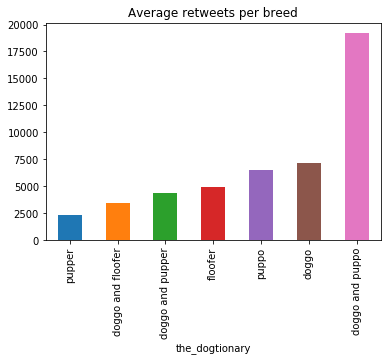

In [129]:
master_df = twitter_archive_clean_v6
a=master_df.groupby(['the_dogtionary']).retweet_count.mean().sort_values(ascending=False)[12::-1]
a.plot.bar(title='Average retweets per breed')

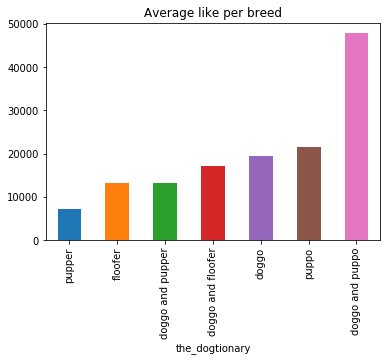

In [104]:
a=master_df.groupby(['the_dogtionary']).favorite_count.mean().sort_values(ascending=False)[12::-1]
a.plot.bar(title='Average like per breed')

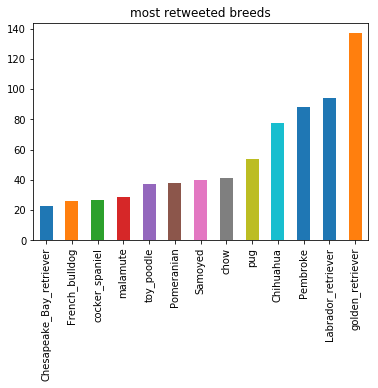

In [112]:
a=master_df[master_df['is_first_prediction_dog']==True]
b=a['first_prediction'].value_counts().sort_values(ascending=False)[12::-1]
b.plot.bar(title='most retweeted breeds')